In [1]:
!git clone https://github.com/dfeddema/tiny_results_v0.5.git

fatal: destination path 'tiny_results_v0.5' already exists and is not an empty directory.


In [2]:
!find . -print | grep prepare_training_env.sh

./tiny/v0.5/training/image_classification/prepare_training_env.sh
./tiny/v0.5/training/anomaly_detection/prepare_training_env.sh
./tiny_results_v0.5/closed/PengChengLaboratory/code/ad/tiny/v0.1/training/anomaly_detection/prepare_training_env.sh
./tiny_results_v0.5/closed/reference/code/training/image_classification/prepare_training_env.sh
./tiny_results_v0.5/closed/reference/code/training/anomaly_detection/prepare_training_env.sh


In [3]:
!./tiny/v0.5/training/image_classification/prepare_training_env.sh

You should consider upgrading via the 'pip install --upgrade pip' command.


In [4]:
! cd ./tiny/v0.5/training/image_classification 
!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
!tar -xvf cifar-10-python.tar.gz

--2021-08-04 16:55:56--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz.2’

cifar-10-python.tar 100%[===================>] 162.60M  60.9MB/s    in 2.7s    

2021-08-04 16:55:59 (60.9 MB/s) - ‘cifar-10-python.tar.gz.2’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [5]:
!find . -print | grep  perf_samples_loader.py

./tiny/v0.5/training/image_classification/perf_samples_loader.py
./tiny_results_v0.5/closed/PengChengLaboratory/code/ad/tiny/v0.1/training/image_classification/perf_samples_loader.py
./tiny_results_v0.5/closed/reference/code/training/image_classification/perf_samples_loader.py


In [6]:
!cd ./tiny/v0.5/training/image_classification && pip install -r requirements.txt && python perf_samples_loader.py 
##!python train.py && python test.py

You should consider upgrading via the '/opt/app-root/bin/python3.8 -m pip install --upgrade pip' command.
2021-08-04 16:56:06.244231: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


Train data:  (50000, 32, 32, 3)
Train filenames:  (50000,)
Train labels:  (50000, 10)
Test data:  (10000, 32, 32, 3)
Test filenames:  (10000,)
Test labels:  (10000, 10)
Label names:  (10,)


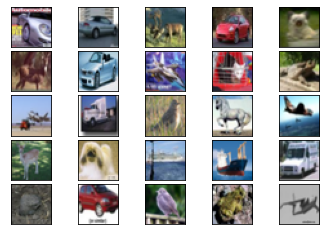

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_27 (Conv2D)              (None, 32, 32, 16)   448         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_21 (BatchNo (None, 32, 32, 16)   64          conv2d_27[0][0]                  
__________________________________________________________________________________________________
activation_21 (Activation)      (None, 32, 32, 16)   0           batch_normalization_21[0][0]     
____________________________________________________________________________________________

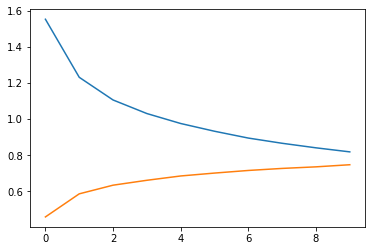

In [12]:
'''
MLCommons
group: TinyMLPerf (https://github.com/mlcommons/tiny)

image classification on cifar10

train.py desc: loads data, trains and saves model, plots training metrics
'''
import sys 
sys.path.insert(0, './tiny_results_v0.5/closed/reference/code/training/image_classification')
import numpy as np
import matplotlib.pyplot as plt
import pickle
import tensorflow as tf
from keras.callbacks import LearningRateScheduler
from keras.utils import to_categorical
import keras_model

import datetime

EPOCHS = 10
BS = 32

# get date ant time to save model
dt = datetime.datetime.today()
year = dt.year
month = dt.month
day = dt.day
hour = dt.hour
minute = dt.minute

"""
The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 
training images and 10000 test images.
The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains 
exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random 
order, but some training batches may contain more images from one class than another. Between them, the training 
batches contain exactly 5000 images from each class.
"""

#learning rate schedule
def lr_schedule(epoch):
    initial_learning_rate = 0.001
    decay_per_epoch = 0.99
    lrate = initial_learning_rate * (decay_per_epoch ** epoch)
    print('Learning rate = %f'%lrate)
    return lrate

lr_scheduler = LearningRateScheduler(lr_schedule)

#optimizer
optimizer = tf.keras.optimizers.Adam()

#define data generator
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    #brightness_range=(0.9, 1.2),
    #contrast_range=(0.9, 1.2),
    validation_split=0.2
)

def unpickle(file):
    """load the cifar-10 data"""

    with open(file, 'rb') as fo:
        data = pickle.load(fo, encoding='bytes')
    return data


def load_cifar_10_data(data_dir, negatives=False):
    """
    Return train_data, train_filenames, train_labels, test_data, test_filenames, test_labels
    """

    # get the meta_data_dict
    # num_cases_per_batch: 1000
    # label_names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    # num_vis: :3072

    meta_data_dict = unpickle(data_dir + "/batches.meta")
    cifar_label_names = meta_data_dict[b'label_names']
    cifar_label_names = np.array(cifar_label_names)

    # training data
    cifar_train_data = None
    cifar_train_filenames = []
    cifar_train_labels = []

    for i in range(1, 6):
        cifar_train_data_dict = unpickle(data_dir + "/data_batch_{}".format(i))
        if i == 1:
            cifar_train_data = cifar_train_data_dict[b'data']
        else:
            cifar_train_data = np.vstack((cifar_train_data, cifar_train_data_dict[b'data']))
        cifar_train_filenames += cifar_train_data_dict[b'filenames']
        cifar_train_labels += cifar_train_data_dict[b'labels']

    cifar_train_data = cifar_train_data.reshape((len(cifar_train_data), 3, 32, 32))
    if negatives:
        cifar_train_data = cifar_train_data.transpose(0, 2, 3, 1).astype(np.float32)
    else:
        cifar_train_data = np.rollaxis(cifar_train_data, 1, 4)
    cifar_train_filenames = np.array(cifar_train_filenames)
    cifar_train_labels = np.array(cifar_train_labels)

    cifar_test_data_dict = unpickle(data_dir + "/test_batch")
    cifar_test_data = cifar_test_data_dict[b'data']
    cifar_test_filenames = cifar_test_data_dict[b'filenames']
    cifar_test_labels = cifar_test_data_dict[b'labels']

    cifar_test_data = cifar_test_data.reshape((len(cifar_test_data), 3, 32, 32))
    if negatives:
        cifar_test_data = cifar_test_data.transpose(0, 2, 3, 1).astype(np.float32)
    else:
        cifar_test_data = np.rollaxis(cifar_test_data, 1, 4)
    cifar_test_filenames = np.array(cifar_test_filenames)
    cifar_test_labels = np.array(cifar_test_labels)

    return cifar_train_data, cifar_train_filenames, to_categorical(cifar_train_labels), \
        cifar_test_data, cifar_test_filenames, to_categorical(cifar_test_labels), cifar_label_names


if __name__ == "__main__":
    """load cifar10 data and trains model"""

    cifar_10_dir = 'cifar-10-batches-py'

    train_data, train_filenames, train_labels, test_data, test_filenames, test_labels, label_names = \
        load_cifar_10_data(cifar_10_dir)

    print("Train data: ", train_data.shape)
    print("Train filenames: ", train_filenames.shape)
    print("Train labels: ", train_labels.shape)
    print("Test data: ", test_data.shape)
    print("Test filenames: ", test_filenames.shape)
    print("Test labels: ", test_labels.shape)
    print("Label names: ", label_names.shape)

    # Don't forget that the label_names and filesnames are in binary and need conversion if used.

    # display some random training images in a 25x25 grid
    num_plot = 5
    f, ax = plt.subplots(num_plot, num_plot)
    for m in range(num_plot):
        for n in range(num_plot):
            idx = np.random.randint(0, train_data.shape[0])
            ax[m, n].imshow(train_data[idx])
            ax[m, n].get_xaxis().set_visible(False)
            ax[m, n].get_yaxis().set_visible(False)
    f.subplots_adjust(hspace=0.1)
    f.subplots_adjust(wspace=0)
    plt.show()

    new_model = keras_model.resnet_v1_eembc()
    new_model.summary()

    # compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied)
    datagen.fit(train_data)

    new_model.compile(
        optimizer=optimizer, loss='categorical_crossentropy', metrics='accuracy', loss_weights=None,
        weighted_metrics=None, run_eagerly=None )

    # fits the model on batches with real-time data augmentation:
    History = new_model.fit(datagen.flow(train_data, train_labels, batch_size=BS),
              steps_per_epoch=len(train_data) / BS, epochs=EPOCHS, callbacks=[lr_scheduler])

    plt.plot(np.array(range(EPOCHS)), History.history['loss'])
    plt.plot(np.array(range(EPOCHS)), History.history['accuracy'])
    plt.savefig('train_loss_acc.png')
    model_name = "trainedResnet.h5"
    new_model.save("trained_models/" + model_name)